## Exercício 1

Siga o tutorial do site [Physics-informed Neural Networks: a simple tutorial with PyTorch](https://medium.com/@theo.wolf/physics-informed-neural-networks-a-simple-tutorial-with-pytorch-f28a890b874a). Neste exemplo, você irá resolver a EDO do resfriamento de uma caneca de café em etapas:

1. Resolva analiticamente a EDO do resfriamento de uma caneca de café. A equação é dada por:

```math
   \frac{dT}{dt} = r(T_{amb} - T)
```
onde $T$ é a temperatura do café, $T_{amb} = 25$ ºC é a temperatura ambiente e $r = 0.005$ 1/s é uma taxa de resfriamento.

2. Resolva a EDO usando o método de Runge-Kutta de quarta ordem (RK4) e compare com a solução analítica. Use o comando `scipy.integrate.solve_ivp`.

3. Usando a solução analítica, ou RK4, gere dados sintéticos para treinar a PINN. Cerca de 10 pontos no intervalo de 0 a 200 segundos (veja exemplo no tutorial). Some um ruído gaussiano com média 0 e desvio padrão 0.5 em cada ponto.

4. Tente usar uma NN de regressão simples para ajustar os dados sintéticos e extrapolar para tempos maiores (até 1000 segundos). Compare com a solução analítica. Sabemos que a extrapolação será péssima.

5. Agora, siga o tutorial e implemente a PINN incluindo as restrições físicas na minimização da perda, mas assumindo que conhecemos o valor da taxa $r = 0.005$ 1/s. Compare com a solução analítica e com a NN de regressão simples.

6. Ainda seguindo o tutorial, implemente a PINN sem conhecer o valor da taxa $r$. A rede deve ser capaz de descobrir o valor correto. Compare com a solução analítica e com a NN de regressão simples.

In [1]:
import numpy as np
import tensorflow as tf

In [3]:
def grad(outputs, inputs):
    """Computes the partial derivative of an output with respect to an input."""
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        grads = tape.gradient(outputs, inputs)
    return grads

def physics_loss(model, R, Tenv):
    """The physics loss of the model."""
    # Create collocation points
    ts = tf.linspace(0, 1000, num=1000)[:, tf.newaxis]  # Shape (1000, 1)
    ts = tf.Variable(ts, trainable=True)  # Ensure `ts` is differentiable

    # Run the collocation points through the network
    temps = model(ts)

    # Get the gradient
    with tf.GradientTape() as tape:
        tape.watch(ts)
        dT = tape.gradient(temps, ts)

    # Compute the ODE
    ode = dT - R * (Tenv - temps)

    # MSE of ODE
    return tf.reduce_mean(tf.square(ode))

In [5]:
class Net(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super(Net, self).__init__(*args, **kwargs)
        # Make r a trainable variable
        self.r = tf.Variable(0.0, trainable=True, dtype=tf.float32)

    def call(self, inputs):
        # Define the forward pass (to be implemented based on your architecture)
        pass

def physics_loss_discovery(model, Tenv):
    """Physics loss for discovering the parameter r."""
    # Create collocation points
    ts = tf.linspace(0, 1000, num=1000)[:, tf.newaxis]  # Shape (1000, 1)
    ts = tf.Variable(ts, trainable=True)  # Ensure `ts` is differentiable

    # Run the collocation points through the network
    temps = model(ts)

    # Compute the gradient of temps with respect to ts
    with tf.GradientTape() as tape:
        tape.watch(ts)
        dT = tape.gradient(temps, ts)

    # Use the differentiable parameter r
    pde = model.r * (Tenv - temps) - dT

    # Return the mean squared error of the PDE residual
    return tf.reduce_mean(tf.square(pde))

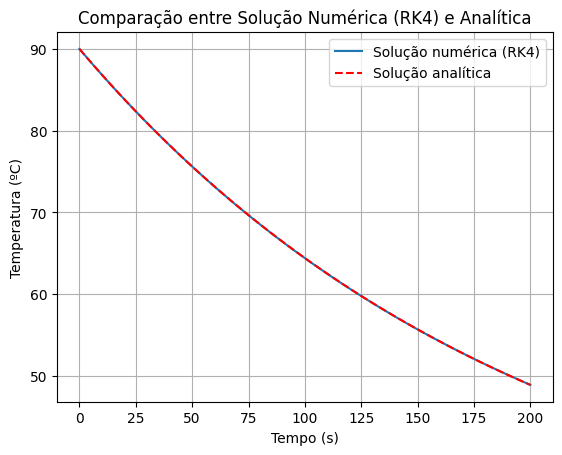

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Definindo a EDO: dT/dt = r * (T_amb - T)
def cooling(t, T, r=0.005, T_amb=25):
    return r * (T_amb - T)

# Condição inicial e tempo
T0 = 90  # Temperatura inicial (em ºC)
t_span = (0, 200)  # Intervalo de tempo
t_eval = np.linspace(0, 200, 100)  # Pontos de avaliação

# Resolvendo a EDO com o solver Runge-Kutta
sol = solve_ivp(cooling, t_span, [T0], t_eval=t_eval)

# Plotando a solução
plt.plot(sol.t, sol.y[0], label="Solução numérica (RK4)")

# Solução analítica
T_analyt = 25 + (T0 - 25) * np.exp(-0.005 * sol.t)
plt.plot(sol.t, T_analyt, '--', label="Solução analítica", color='red')

plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (ºC)")
plt.legend()
plt.title("Comparação entre Solução Numérica (RK4) e Analítica")
plt.grid(True)
plt.show()


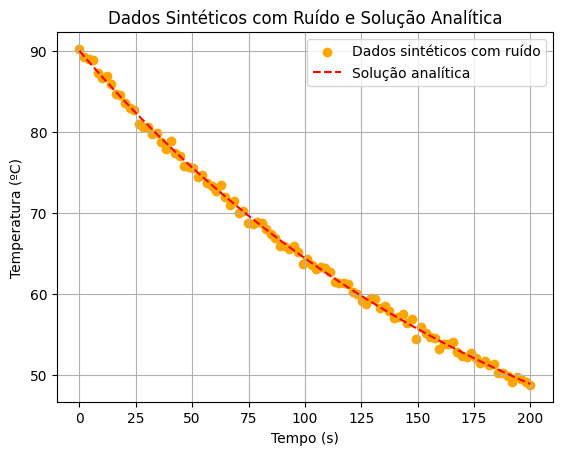

In [3]:
# Gerando dados sintéticos com ruído
np.random.seed(42)
synthetic_data = T_analyt + np.random.normal(0, 0.5, size=len(sol.t))

# Plotando os dados sintéticos
plt.scatter(sol.t, synthetic_data, label="Dados sintéticos com ruído", color='orange')
plt.plot(sol.t, T_analyt, '--', label="Solução analítica", color='red')

plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (ºC)")
plt.legend()
plt.title("Dados Sintéticos com Ruído e Solução Analítica")
plt.grid(True)
plt.show()


c:\Users\pf010\AppData\Local\miniconda3\envs\tensorflow-env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


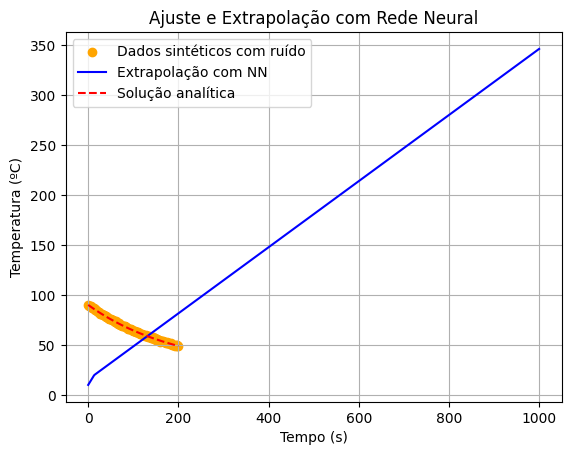

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Convertendo os dados para tensores
X_train = tf.convert_to_tensor(sol.t.reshape(-1, 1), dtype=tf.float32)
y_train = tf.convert_to_tensor(synthetic_data.reshape(-1, 1), dtype=tf.float32)

# Definindo a arquitetura da rede neural
model = models.Sequential([
    layers.Dense(10, activation='relu', input_dim=1),
    layers.Dense(1)
])

# Compilando o modelo
model.compile(optimizer='adam', loss='mse')

# Treinando a rede
model.fit(X_train, y_train, epochs=1000, verbose=0)

# Extrapolando a rede neural
X_test = np.linspace(0, 1000, 1000).reshape(-1, 1)
y_pred = model.predict(X_test)

# Plotando a previsão da rede neural
plt.scatter(sol.t, synthetic_data, label="Dados sintéticos com ruído", color='orange')
plt.plot(X_test, y_pred, label="Extrapolação com NN", color='blue')
plt.plot(sol.t, T_analyt, '--', label="Solução analítica", color='red')

plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (ºC)")
plt.legend()
plt.title("Ajuste e Extrapolação com Rede Neural")
plt.grid(True)
plt.show()


Epoch [0/1000], Loss: 22677.0273
Epoch [100/1000], Loss: 1845.5632
Epoch [200/1000], Loss: 1801.3597
Epoch [300/1000], Loss: 1755.6399
Epoch [400/1000], Loss: 1702.7385
Epoch [500/1000], Loss: 1639.9188
Epoch [600/1000], Loss: 1562.0663
Epoch [700/1000], Loss: 1461.8717
Epoch [800/1000], Loss: 1331.2577
Epoch [900/1000], Loss: 1165.4208


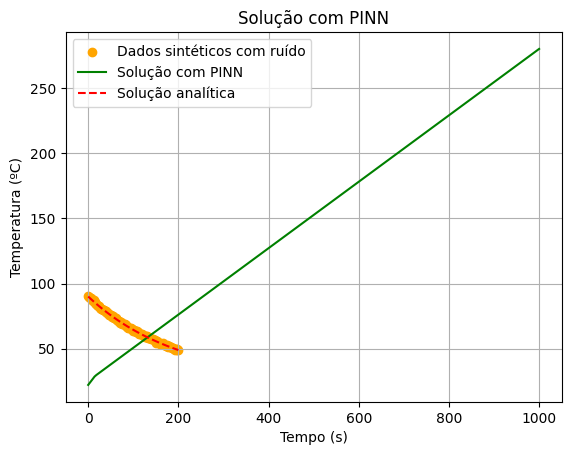

In [5]:
class PINN(tf.keras.Model):
    def __init__(self, r=0.005):
        super(PINN, self).__init__()
        self.dense1 = layers.Dense(10, activation='relu', input_dim=1)
        self.dense2 = layers.Dense(1)
        self.r = r  # Taxa de resfriamento fixa

    def call(self, t):
        t = self.dense1(t)
        t = self.dense2(t)
        return t

    def physics_loss(self, t, T):
        # Calculando a derivada de T em relação a t
        with tf.GradientTape() as tape:
            tape.watch(t)
            T_pred = self.call(t)
        dTdt = tape.gradient(T_pred, t)
        T_amb = 25
        # Calculando a perda física (restrição)
        loss = tf.reduce_mean(tf.square(dTdt - self.r * (T_amb - T_pred)))
        return loss

# Inicializando e treinando a PINN
model_pinn = PINN(r=0.005)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Treinando a PINN
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_pred = model_pinn(X_train)
        loss = tf.reduce_mean(tf.square(T_pred - y_train)) + model_pinn.physics_loss(X_train, T_pred)
    grads = tape.gradient(loss, model_pinn.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_pinn.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.numpy():.4f}")

# Plotando a solução da PINN
T_pinn = model_pinn(X_test).numpy()
plt.scatter(sol.t, synthetic_data, label="Dados sintéticos com ruído", color='orange')
plt.plot(X_test, T_pinn, label="Solução com PINN", color='green')
plt.plot(sol.t, T_analyt, '--', label="Solução analítica", color='red')

plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (ºC)")
plt.legend()
plt.title("Solução com PINN")
plt.grid(True)
plt.show()


In [6]:
class PINN_r_unknown(tf.keras.Model):
    def __init__(self):
        super(PINN_r_unknown, self).__init__()
        self.dense1 = layers.Dense(10, activation='relu', input_dim=1)
        self.dense2 = layers.Dense(1)
        self.r = tf.Variable(0.005, dtype=tf.float32, trainable=True)  # r é agora uma variável treinável

    def call(self, t):
        t = self.dense1(t)
        t = self.dense2(t)
        return t

    def physics_loss(self, t, T):
        # Calculando a derivada de T em relação a t
        with tf.GradientTape() as tape:
            tape.watch(t)
            T_pred = self.call(t)
        dTdt = tape.gradient(T_pred, t)
        T_amb = 25
        # Calculando a perda física (restrição) com o valor de r treinável
        loss = tf.reduce_mean(tf.square(dTdt - self.r * (T_amb - T_pred)))
        return loss

# Inicializando e treinando a PINN
model_pinn_r_unknown = PINN_r_unknown()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Treinando a PINN
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_pred = model_pinn_r_unknown(X_train)
        loss = tf.reduce_mean(tf.square(T_pred - y_train)) + model_pinn_r_unknown.physics_loss(X_train, T_pred)
    grads = tape.gradient(loss, model_pinn_r_unknown.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_pinn_r_unknown.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.numpy():.4f}, r: {model_p


SyntaxError: incomplete input (3566642718.py, line 38)